In [ ]:
!chmod 600 ~/.passwd-s3fs

In [ ]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
s3fs is already the newest version (1.82-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!mkdir /s3

mkdir: cannot create directory ‘/s3’: File exists
s3fs: MOUNTPOINT directory /s3 is not empty. if you are sure this is safe, can use the 'nonempty' mount option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob

In [ ]:
df = pd.read_csv('/nih_split.csv')

In [ ]:
#Credit to the following code: https://www.kaggle.com/code/mqadii/nih-chest-x-ray-multi-classification
my_paths = glob('/s3/NIH_Clinical_Center_Chest_X-Ray_Data/Images/images*/images/*.png')
print('Number of Observations: ', len(my_paths))
img_full_paths = {os.path.basename(x): x for x in my_paths}

Number of Observations:  112120


In [ ]:
df['Path'] = df['Image Index'].map(img_full_paths.get)
df['Path'] = df['Path'].str[1:]

In [ ]:
train_df = df[df.split=='train']
val_df = df[df.split=='val']
test_df = df[df.split=='test']

In [ ]:
train_df.insert(loc = 1, column = 'Valid_Column', value = False)
val_df.insert(loc = 1, column = 'Valid_Column', value = True)
training_df = pd.concat([train_df, val_df])

In [ ]:
path = '/'
dls_gender = ImageDataLoaders.from_df(training_df, path, fn_col='Path', label_col='Gender', valid_col = 'Valid_Column', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), num_workers=0)
dls_age = ImageDataLoaders.from_df(training_df, path, fn_col='Path', label_col='Patient Age Category', valid_col = 'Valid_Column', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), num_workers=0)

In [ ]:
learn_gender = vision_learner(dls_gender, resnet34, metrics=accuracy)
learn_age = vision_learner(dls_age, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.00363078061491251)

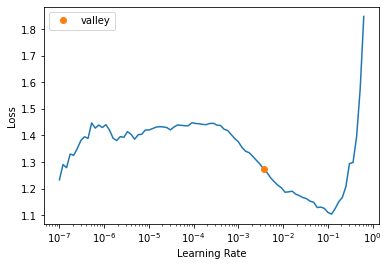

In [ ]:
learn_gender.lr_find()

SuggestedLRs(valley=0.0020892962347716093)

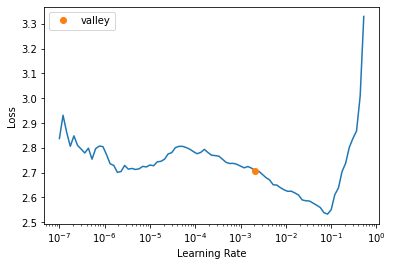

In [ ]:
learn_age.lr_find()

In [ ]:
learn_gender.fine_tune(20, base_lr = 3.6e-3, cbs = [EarlyStoppingCallback(monitor = 'accuracy', min_delta = 0.01, patience = 3), SaveModelCallback(monitor='accuracy', min_delta = 0.01)])


epoch,train_loss,valid_loss,accuracy,time
0,0.100087,0.106302,0.968663,3:56:20


Better model found at epoch 0 with accuracy value: 0.9686629772186279.


epoch,train_loss,valid_loss,accuracy,time
0,0.105930,0.079414,0.968489,3:59:53
1,0.065233,0.064840,0.973276,4:03:36
2,0.033671,0.061290,0.977107,4:12:31


Better model found at epoch 0 with accuracy value: 0.968488872051239.


In [ ]:
learn_gender.export(fname = '/content/sample_data/nih_gender.pkl')

In [ ]:
learn_age.fine_tune(20, base_lr = 2e-3, cbs = [EarlyStoppingCallback(monitor = 'accuracy', min_delta = 0.01, patience = 3), SaveModelCallback(monitor='accuracy', min_delta = 0.01)])

epoch,train_loss,valid_loss,accuracy,time
0,1.013620,0.912050,0.578430,4:39:32


Better model found at epoch 0 with accuracy value: 0.578429639339447.


epoch,train_loss,valid_loss,accuracy,time
0,0.721568,0.686042,0.687674,4:23:01


Better model found at epoch 0 with accuracy value: 0.6876741051673889.


epoch,train_loss,valid_loss,accuracy,time
0,0.721568,0.686042,0.687674,4:23:01
1,0.646292,0.633436,0.717183,4:29:20
2,0.589141,0.647253,0.707173,4:25:23
3,0.569570,0.669680,0.710916,4:24:43
4,0.528105,0.669858,0.710045,4:30:01


Better model found at epoch 1 with accuracy value: 0.7171831727027893.
No improvement since epoch 1: early stopping


In [ ]:
learn_age.export(fname = '/content/sample_data/nih_age.pkl')